# Drug sensitivity prediction using regression models 

In this notebook, we will implement a simple machine learning project, focusing on regression methods, in particular, sparse linear regression and nonlinear regression (regression trees). The aim is to build robust  genomic predictor of response to anticancer drugs. We will apply these methods to accurately predict drug sensitivity according to gene expression profile in cance cell lines. In paritcular, we will focus on Paclitaxel sensitivity prediction in the CCLE database.

# Dataset

Gene expression features and drug sensitivity data in Cancer Cell Line Encyclopedia (CCLE) are used to build a model for Paclitaxel sensitivity prediction in cancer cell lines. A dataset of 503 cell lines and their corresponding gene expression profiles was built by using *PharmacoGx*, an R package enabling users to download and interrogate large pharmacogenomic datasets, including the CCLE and GDSC databases.*PharmacoGx* was also used to download the area under dose–response curves to evaluate the sensitivity of Paclitaxel to a given cell line. 

**Objective**: to predict the drug sensitivity scores from gene expression information which makes this a supervised, regression task.

# Workflow

1. Importing the Python modules for ML
2. Check and prepare your dataset
3. Train-test splitting
4. Train models on the training set
5. Evaluation of model performance with the test set
5. Extract and visualize evaluation metrics
6. Extract and visualize feature importance
7. Save the result. 

# Importing the modules

The first step is to import the required Python libraries. Sometimes, it is convenient to import only the functions that are needed rather than import the whole module.

In [ ]:
# Pandas and numpy for data manipulation
import numpy as np           
import pandas as pd 
# Scipy functions for mathematics
import scipy as sp  
# Sklearn 
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
# Interacting with your os and managing warning message
import os
import warnings 

Check (or set) your working directory. 

In [ ]:
warnings.simplefilter('ignore')
dirname = os.getcwd()
os.listdir() 

# Data exploration and preparation

The input dataset contains gene expression profiles (features) and drug sensitivity data. Primary phenotypic responses measured in pharmacogenomic studies include dose–response curves and two related measures of drug sensitivity: the IC50 value and the area under the dose–response curve, namely AUC (referred to as ActArea in CCLE). The IC50 is reported as *-log10(IC50)*, where IC50 is the concentration at which the compound reaches 50% reduction in cell viability.

In [3]:
df_mrna = pd.read_csv('ccle_pacl_mrna_1000.csv', index_col=0)
df_mrna.shape

(503, 1002)

Get the list of column headers or column name

In [4]:
# index indicates the row names
list(df_mrna.index)[:5]

['22RV1', '5637', '639-V', '697', '769-P']

Inspecting the target variable

In [5]:
df_mrna[['auc','neg_log_ic50']].head(3)

,auc,neg_log_ic50
22RV1,0.748243,2.038365
5637,0.922079,2.537686
639-V,0.787487,2.197659


**Checking and dropping missing values**

In [6]:
# Counting cells with missing values
print(sum(df_mrna.isnull().values.ravel()))
# Counting rows that have missing values
print(sum([True for idx,row in df_mrna.iterrows() if any(row.isnull())]))
# Removing missing values
df_mrna = df_mrna.dropna()
df_mrna.shape

14000
14


(489, 1002)

Get row names

In [7]:
genes = df_mrna.columns.values[:1000]
print(genes[:10])

['ENSG00000171345_at' 'ENSG00000119888_at' 'ENSG00000147676_at'
 'ENSG00000120708_at' 'ENSG00000152661_at' 'ENSG00000196139_at'
 'ENSG00000026025_at' 'ENSG00000122862_at' 'ENSG00000118785_at'
 'ENSG00000163453_at']


Define the target variable

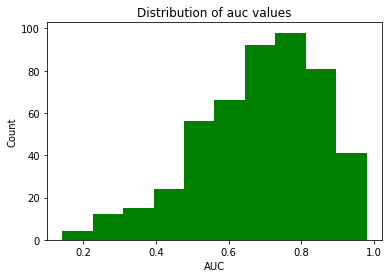

In [8]:
y = df_mrna['auc'].values
plt.hist(y, color='g')
plt.xlabel('AUC'); plt.ylabel('Count'); plt.title('Distribution of auc values');

Visualize the IC50 scores (which are log-normalized). IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. Therefore we will use the negative values of the log(IC50) so that higher values will match with more sensitive cell lines. 

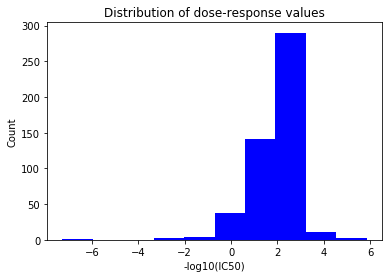

In [9]:
df_mrna = df_mrna.replace([np.inf, -np.inf], 0)
test_ic50 = df_mrna['neg_log_ic50'].values
plt.hist(test_ic50 , color='b')
plt.xlabel('-log10(IC50)'); plt.ylabel('Count'); plt.title('Distribution of dose-response values');

**Feature scaling**

In [10]:
X_raw = df_mrna.iloc[:,0:df_mrna.shape[1]-2].values
print('Raw feature min = {}, max = {}'.format(X_raw.min(), X_raw.max()))
X = preprocessing.scale(X_raw)
print('Scaled feature min = {}, max = {}'.format(X.min(), X.max()))

Raw feature min = 2.79385514225975, max = 14.882913006338699
Scaled feature min = -4.6129725464298845, max = 5.776765912851032


Scaled data has zero mean and unit variance

In [11]:
print(np.abs(np.round(X.mean(axis=0), 5)[:10]))
print(np.round(X.std(axis=0), 5)[:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Features are now more consistent with each other. We will be able to evaluate the output of our trained models better.

**Feature reduction**

Feature reduction is conducted with univariate linear regression tests.

In [12]:
# will return a new array where the feature set has been reduced to the best 'k'.
b = SelectKBest(f_regression, k=300) # k is number of features.
X_red = b.fit_transform(X, y)
genes_200 = genes[b.get_support()]
print(X_red.shape)

(489, 300)


# Training and validation

Split in training and validation set

In [29]:
tr_samples = int(0.6 * X_red.shape[0])
train_x = X_red[0:tr_samples,:]
test_x  = X_red[tr_samples:X_red.shape[0],:]
train_y = y[0:tr_samples]
test_y  = y[tr_samples:X_red.shape[0]]

Check the sizes

In [30]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(293, 300)
(196, 300)
(293,)
(196,)


Define the models

In [32]:
# Regularized regression
lm_elanet = ElasticNetCV(max_iter=1000)
lm_lasso = LassoCV(max_iter=1000)
# Non linear regression (regression trees)
nlm_rfo = RandomForestRegressor(n_estimators = 200)
nlm_gbt = GradientBoostingRegressor(n_estimators = 200)

Fit the selected models on the training data

In [33]:
np.random.seed(0)
lm_elanet.fit(train_x, train_y);
lm_lasso.fit(train_x, train_y);
nlm_rfo.fit(train_x, train_y);
nlm_gbt.fit(train_x, train_y);

Evaluate the prediction

In [34]:
print(lm_elanet.alpha_)
print(lm_lasso.alpha_)

0.02063598140317133
0.010317990701585664


In [35]:
pred_test_elanet = lm_elanet.predict(test_x)
pred_test_lasso = lm_lasso.predict(test_x)
pred_test_rfo = nlm_rfo.predict(test_x)
pred_test_gbt = nlm_gbt.predict(test_x)

# Evaluation metrics

Metrics are needed to evaluate how good are the fitted models. A well-fitting regression model results in predicted values close to the observed data values. 

R-squared (R2) indicates percent of the prediction error in the target variable which is eliminated when we use regression on the input variables. The value ranges between 0 and 1.

Two statistics are used in this exercise to evaluate model fit: the R-squared and the Root Mean Square Error (RMSE). They are based on two sums of squares: Sum of Squares Total (SST) and Sum of Squares Error (SSE).


Other relevant regression/related metrics are described in http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics.

The total sum of squares (proportional to the variance of the data) measures how far the data are from the mean.

\begin{equation*}
SST = \sum_{i} (y_i-\hat{y})^2
\end{equation*}

The sum of squares of residuals, instead, measures how far the data are from the model’s predicted values.

\begin{equation*}
SSE = \sum_{i} (y_i - f_i)^2 = \sum_{i} e_i^2
\end{equation*}

The difference between SST and SSE is the improvement in prediction from the regression model, compared to the mean model. Dividing that difference by SST gives R-squared. It is the proportional improvement in prediction from the regression model, compared to the mean model. It indicates the goodness of fit of the model.

\begin{equation*}
R^2 = 1-\frac{SSE}{SST}
\end{equation*}

The mean squared error *MSE* is the SSE divided by the degrees of freedom for the errors *v=n-m* (n minus the number of fitted coefficients m estimated from the response values).

\begin{equation*}
RMSE = \sqrt{MSE} = SSE/v
\end{equation*}

In [20]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from math import sqrt

Calculate the R-squared

In [36]:
r2_elanet = round(r2_score(test_y, pred_test_elanet),3)
r2_lasso = round(r2_score(test_y, pred_test_lasso),3)
r2_rfo = round(r2_score(test_y, pred_test_rfo),3)    
r2_gbt = round(r2_score(test_y, pred_test_gbt),3)   
r2_scores = [r2_elanet,r2_lasso,r2_rfo,r2_gbt]
print(r2_scores)

[0.235, 0.234, 0.242, 0.117]


**Calculate the RMSE**

The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

In [37]:
rmse_elanet = round(sqrt(mean_squared_error(test_y, pred_test_elanet)),3)
rmse_lasso = round(sqrt(mean_squared_error(test_y, pred_test_lasso)),3)
rmse_rfo = round(sqrt(mean_squared_error(test_y, pred_test_rfo)),3)
rmse_gbt = round(sqrt(mean_squared_error(test_y, pred_test_gbt)),3)
rmse_scores = [rmse_elanet,rmse_lasso,rmse_rfo,rmse_gbt]
print(rmse_scores)

[0.145, 0.145, 0.145, 0.156]


Calculates a Pearson correlation coefficient and the p-value for testing non-correlation.

In [38]:
sp_elanet, p_sp_elanet = sp.stats.pearsonr(pred_test_elanet, test_y)
sp_lasso, p_sp_lasso = sp.stats.pearsonr(pred_test_lasso, test_y)
sp_rfo, p_sp_rfo = sp.stats.pearsonr(pred_test_rfo, test_y)
sp_gbt, p_sp_gbt = sp.stats.pearsonr(pred_test_gbt, test_y)
cor_scores = [sp_elanet, sp_lasso, sp_rfo, sp_gbt]
print(cor_scores)

[0.5068577016246663, 0.5057980986986321, 0.5303396490901682, 0.4079841856733755]


# Diagnostic plots

Scatter plot to compare true sensitivity scores against the predicted scores.

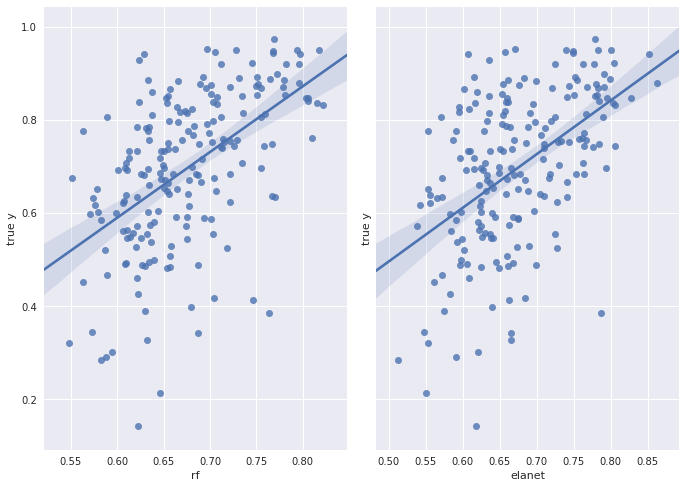

In [39]:
import seaborn as sns
sns.set(style="darkgrid")
d = {'rf': pred_test_rfo, 'elanet': pred_test_elanet,'y':test_y}
data_plt = pd.DataFrame(data=d)
# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(data_plt, x_vars=('rf','elanet'), 
                 y_vars='y', size=7, aspect=0.7, 
                 palette="Set2", kind = 'reg')
p.set(ylabel='true y')
plt.show()

# Concordance Index

The concordance index (c-index) is a nonparametric scoring method that provides a measure of similarity between two lists of measurements or ranks. 

i.e. the probability that, for a pair of randomly chosen comparable samples, the sample with the higher risk prediction will experience an event before the other sample or belongs to a higher binary class. 

In the presented case study, for a given drug $d$, we measure the $cindex$ between a predicited ranked list of cell lines $R_d={r_1,r_2,...,r_n}$ (where $r_i$ is the rank order of cell line $i$), and the dose response values for the same $n$ cell lines $G_d= {g_1,g_2,...,g_n}$ (where $g_i$ is the $-log_{10}(\text{IC50})$ values for cell line $i$). 

\begin{equation*}
cindex = c(G_d, R_d) = \frac{2}{n(n-1)} * \sum_{i<j} h(g_i,g_j,r_i,r_j)
\end{equation*}

where

\begin{equation*}
h = \begin{cases}
    1,       & \quad \text{if} (g_i > g_j & r_i < r_j) \bigvee (g_i < g_j & r_i > r_j) \\
    0.5,       & \quad \text{if} (g_i = g_j) \\
    0,       & \quad \text{if} (g_i > g_j & r_i > r_j) \bigvee (g_i < g_j & r_i < r_j)
\end{cases}
\end{equation*}

In [25]:
def cindex(prediction, survtime, survevent):
    count = 0
    score = 0
    N = len(survtime)
    for i in range(0, N-1):
        for j in range(i+1, N): # For each pair of observations
            if (((survevent[i] == True) and (survevent[j] == True)) or \
                ((survevent[i] == True) and (survtime[j] >= survtime[i])) or \
                ((survevent[j] == True) and (survtime[i] >= survtime[j]))):
                # This pair is comparable.
                count = count + 2
                if (survtime[i] < survtime[j]) :
                    if (prediction[i] > prediction[j]) :
                        score = score + 2
                    if (prediction[i] == prediction[j]):
                        score = score + 1  
                if (survtime[i] == survtime[j]) :
                    if (prediction[i] == prediction[j]) :
                        score = score + 2
                if (survtime[i] > survtime[j]):
                    if (prediction[i] < prediction[j]):
                        score = score + 2
                    if (prediction[i] == prediction[j]):
                        score = score + 1
    return score/float(count)

In [26]:
cindex([1,2,3], [1,2,3], [True, True, True])

0.0

In [27]:
cindex([3,2,1], [1,2,3], [True, True, True])

1.0

The concordance index is usually used in survival analysis. But, in this case study, it can be used to simply verify if the most sensitive cell lines are associated with the lowest dose in which 50% inhibition of cell viability occur. 

In [40]:
ic50_test = df_mrna['neg_log_ic50'].values[tr_samples:X_red.shape[0]]
n_tests = len(ic50_test)
ci_elanet = round(cindex(range(n_tests), ic50_test[np.argsort(-pred_test_elanet)], [True] * len(ic50_test)), 2)
ci_lasso = round(cindex(range(n_tests), ic50_test[np.argsort(-pred_test_lasso)], [True] * len(ic50_test)), 2)
ci_rfo = round(cindex(range(n_tests), ic50_test[np.argsort(-pred_test_rfo)], [True] * len(ic50_test)),2)
ci_gbt = round(cindex(range(n_tests), ic50_test[np.argsort(-pred_test_gbt)], [True] * len(ic50_test)),2)
ci_scores = [ci_elanet, ci_lasso, ci_rfo, ci_gbt]
print(ci_scores)

[0.64, 0.64, 0.65, 0.62]


In [41]:
a = np.array([r2_scores,rmse_scores,cor_scores,ci_scores])
dfa = pd.DataFrame(a, index=['R-squared','RMSE','Pearson','Cindex'], 
                   columns=['elanet','lasso','RF','GBT'])
dfa

,ridge,lasso,RF,GBT
R-squared,0.235000,0.234000,0.24200,0.117000
RMSE,0.145000,0.145000,0.14500,0.156000
Pearson,0.506858,0.505798,0.53034,0.407984
Cindex,0.640000,0.640000,0.65000,0.620000


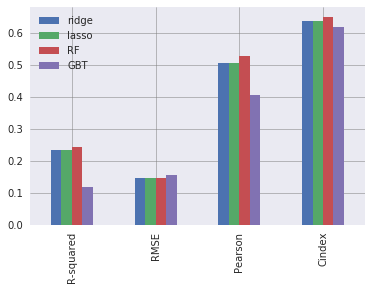

In [42]:
dfa.plot(kind='bar')
# Turn on the grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

# Feature importance

In [43]:
rf_best_10_genes = np.argsort(nlm_rfo.feature_importances_.ravel())[1:10]
print(genes_200[rf_best_10_genes])

['ENSG00000221869_at' 'ENSG00000078401_at' 'ENSG00000145632_at'
 'ENSG00000129354_at' 'ENSG00000139289_at' 'ENSG00000001036_at'
 'ENSG00000163624_at' 'ENSG00000184254_at' 'ENSG00000064042_at']


In [44]:
genes_200[:10]

array(['ENSG00000171345_at', 'ENSG00000147676_at', 'ENSG00000120708_at',
       'ENSG00000122862_at', 'ENSG00000272398_at', 'ENSG00000096696_at',
       'ENSG00000135480_at', 'ENSG00000138772_at', 'ENSG00000118523_at',
       'ENSG00000105974_at'], dtype=object)

In [50]:
# Data frame initialization
method_list = ['Lasso regression', 'Elastic-net',
               'Random forest', 'GBT']
feature_list = list(genes_200)
df_importance = pd.DataFrame(
    columns=method_list, index=feature_list)
df_importance.head()
#
df_importance['Lasso regression'] = lm_lasso.coef_.ravel()
df_importance['Elastic-net'] = lm_elanet.coef_.ravel()
df_importance['Random forest'] = nlm_rfo.feature_importances_.ravel()
df_importance['GBT'] = nlm_gbt.feature_importances_.ravel()
df_importance_sorted = df_importance.sort_values(
    by='Random forest', ascending=False)
df_importance_sorted.head()

,Lasso regression,Elastic-net,Random forest,GBT
ENSG00000182985_at,-0.014692,-0.014567,0.033768,0.011068
ENSG00000127990_at,-0.001567,-0.001753,0.025071,0.010568
ENSG00000143367_at,-0.000000,-0.000000,0.023047,0.005289
ENSG00000253368_at,-0.000000,-0.000000,0.019413,0.002469
ENSG00000171617_at,-0.009697,-0.009551,0.017495,0.014578


**Visualize and compare feature importance**

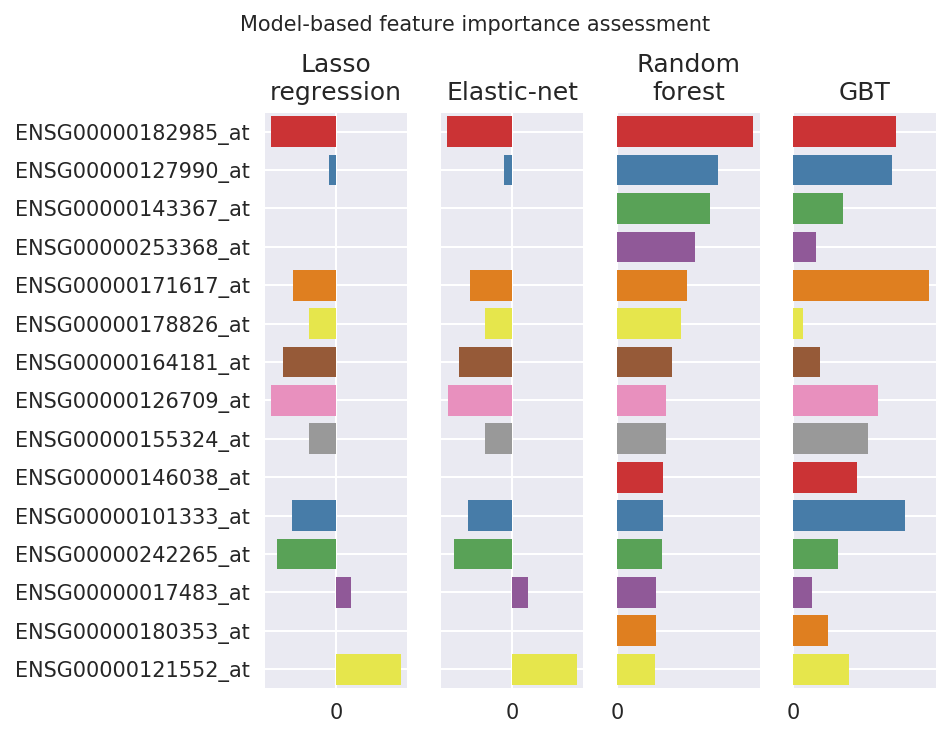

In [51]:
df_importance_sorted = df_importance_sorted.head(15)
fig, ax = plt.subplots(1, 4, sharey='row',
                     figsize=(6.5, 5), dpi=150)
for i, ax_sub in enumerate(ax):
    sns.barplot(x=df_importance_sorted.iloc[:,i].values,
                y=df_importance_sorted.index,
                ax=ax[i],
                palette=sns.color_palette('Set1', n_colors=20))
    sns.despine(left=True, bottom=True)
    ax_sub.set(
        title=df_importance_sorted.columns[i].replace(' ', '\n'),
        xticks=[0])
    ax_sub.grid(True)
plt.tight_layout()
plt.suptitle('Model-based feature importance assessment',
             fontsize=10)
plt.subplots_adjust(top=0.85)
plt.show();

 **Save key outputs for further analysis**

In [57]:
df_importance.to_csv('./feature_importance_eval.csv')
dfa.to_csv('./model_score_eval.csv')

# Conclusions

* It is importnat to measure differen evaluation criteria in order to robustly identify the best models.
* Our analysis revealed that modelling nonlinearities in the data leads to top performances.